# Do not grade between 11/25 and 11/26. Substantial changes being implemented.
## Project 5 - Forecasting Product Demand

In this notebook, we will look at historical data of various product's sales by date. Also included in this dataset are the warehouse the product is shipped from and the category for a specific product. The first step is to read in the data.

In [121]:
import numpy as np
import pandas as pd

original = pd.read_csv("../data/Historical Product Demand.csv")
print(original.head(5))

#we can drop the rows that don't have a date- these happen to be the only rows with NaN. It's okay to just drop them because 
#they represent only ~1% of the data set and the associated data is useless without the date
original.dropna(inplace=True)


   Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500 


In [122]:
#change the type of the input data to be accessible by the models

original['Date'] = pd.to_datetime(original['Date']) 
original.sort_values(['Date'], inplace=True)

original['Order_Demand'] = original['Order_Demand'].replace('[(]', '-', regex=True).astype('str')
original['Order_Demand'] = original['Order_Demand'].replace('[)]', '', regex=True).astype('int')   

original = original.groupby(['Date', 'Product_Code', 'Warehouse', 'Product_Category'])['Order_Demand'].sum().reset_index()

original.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand
0,2011-01-08,Product_0965,Whse_A,Category_006,2
1,2011-05-31,Product_1724,Whse_A,Category_003,108
2,2011-06-24,Product_1521,Whse_S,Category_019,92000
3,2011-09-02,Product_1507,Whse_C,Category_019,1250
4,2011-09-27,Product_0608,Whse_C,Category_001,5


In [123]:
#group by product category

byProdCat = original.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index()
byProdCat.head()

,Date,Product_Category,Order_Demand
0,2011-01-08,Category_006,2
1,2011-05-31,Category_003,108
2,2011-06-24,Category_019,92000
3,2011-09-02,Category_019,1250
4,2011-09-27,Category_001,28


Next we want to do some exploratory analysis on the data. Since the goal is to do a demand forecast, it would be useful to examine the sales over time  by category. However, there are over 2000 products and over 30 categories, so we will just look at an arbitrary two of them. 

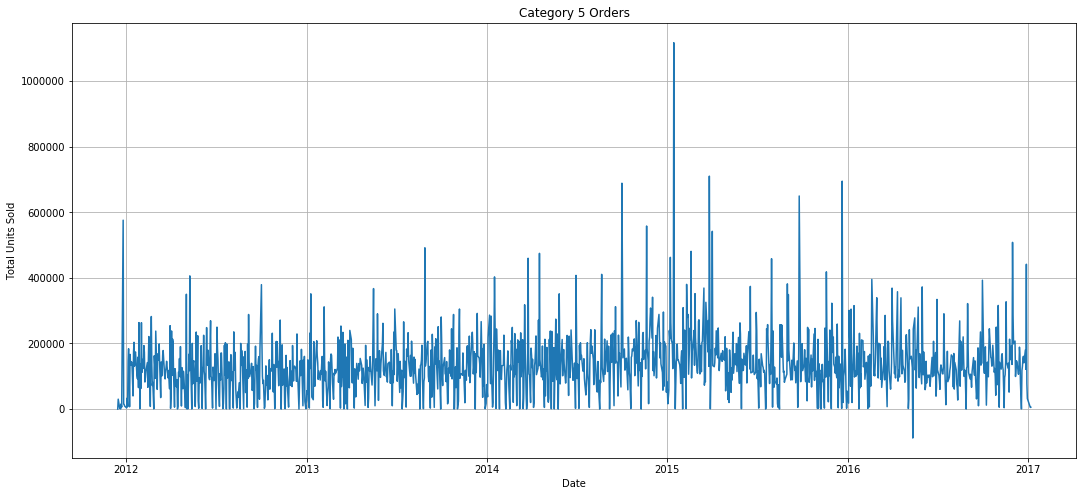

In [124]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

isCat5 = byProdCat['Product_Category'] == 'Category_005'
cat5 = byProdCat[isCat5]
cat5X = cat5['Date']
cat5Y = cat5['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(cat5X, cat5Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Category 5 Orders')
ax.grid()
plt.show()

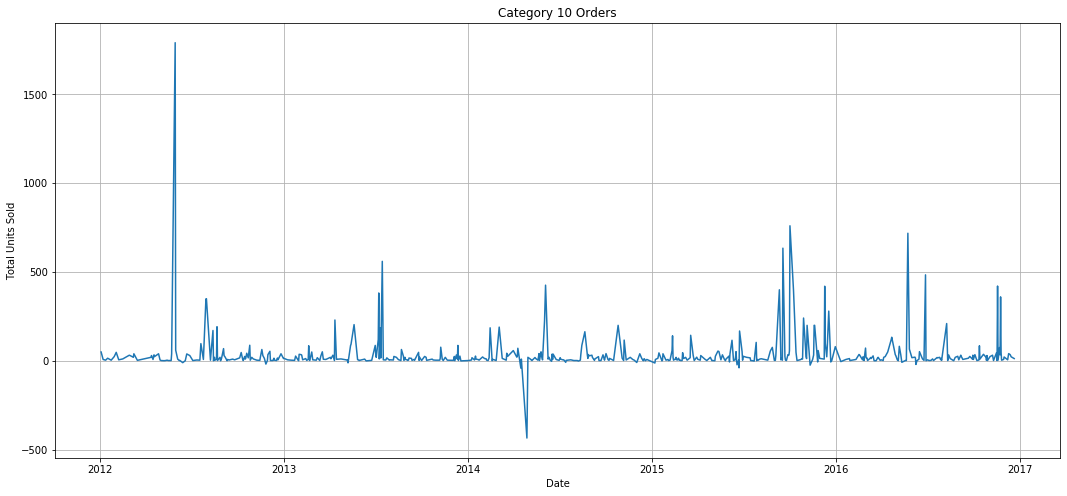

In [125]:
isCat10 = byProdCat['Product_Category'] == 'Category_010'
cat10 = byProdCat[isCat10]
cat10X = cat10['Date']
cat10Y = cat10['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(cat10X, cat10Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Category 10 Orders')
ax.grid()
plt.show()

It appears that there is strong fluctation in Category 10, with a severe outlier in 2012. However, category 5 has much more consistent order quantity, with several outliers throughout. A takeaway from these charts is that it could be useful to cut out the extreme outliers, say any data 2 standard deviations away from the mean. However, we won't do that here to remain in the scope of the project time-wise.

What we do need to do is modify the date, as the models can not train with date times. Therefore, we will break the date up into three columns: day, month, and year. Also, we want to include a days since first date. We also need to convert product category, product code, and warehouse to numeric values. We can use regular expressions to change the product category and product codes to ints and label encoding to modify the warehouse values.

In [144]:
import datetime


original['year'] = pd.DatetimeIndex(original['Date']).year
original['month'] = pd.DatetimeIndex(original['Date']).month
original['day'] = pd.DatetimeIndex(original['Date']).day

date = original.iloc[0]['Date']
original['daysSinceFirst'] = (original['Date'] - date).dt.days
original['Product_Code'] = original['Product_Code'].replace('[Product_]', '', regex=True).astype('int') 
original['Product_Category'] = original['Product_Category'].replace('[Category_]', '', regex=True).astype('int')  



from sklearn import preprocessing
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(original['Warehouse'])
original['Warehouse'] = le.transform(original['Warehouse'])


#index with timestamp
timeIndex = original.set_index('Date')
timeIndex.drop(columns=['year', 'month', 'day'], inplace = True)

original.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,year,month,day,daysSinceFirst
0,2011-01-08,965,0,6,2,2011,1,8,0
1,2011-05-31,1724,0,3,108,2011,5,31,143
2,2011-06-24,1521,3,19,92000,2011,6,24,167
3,2011-09-02,1507,1,19,1250,2011,9,2,237
4,2011-09-27,608,1,1,5,2011,9,27,262


Split data up for training / testing. Take the first 5 years of dates for training, then use the final year for testing. We want to test the last dates in the dataset because our forecasting would be for the future, rather than being interspersed with known values. The reason we aren't doing 80/20 here is because I want to test the seasonality capability. If we only had test data for June - Dec, we woulnd't be able to test how the model does in the new year. The difficulty here is that we are splitting the entire data set, rather than splitting at a product level. What I mean is that we could potentially have a new product that starts shipping at the end of our test data that the model has never seen before. This issue will be addressed later when we build a model for a specific product.

Since the date range is Jan 2011 - Jan 2017, we will use any dates starting in 2016 as test data.

In [127]:
is_post2016 = original['year'] >= 2016
isNot_post2016 = original['year'] < 2016

timeFeatures_Train = original[is_post2016]
timeFeatures_Test = original[isNot_post2016]

timeIndex_Train = timeIndex[:'2015-12-31']
timeIndex_Test = timeIndex['2016-01-01':]

In [128]:
#split training data into X and Y
timeFeatures_train_Y = timeFeatures_Train['Order_Demand']
timeFeatures_train_X = timeFeatures_Train[['year', 'month', 'day', 'daysSinceFirst', 'Product_Category', 'Warehouse', 'Product_Code']]
#split testing data into X and Y
timeFeatures_test_Y = timeFeatures_Test['Order_Demand']
timeFeatures_test_X = timeFeatures_Test[['year', 'month', 'day', 'daysSinceFirst', 'Product_Category', 'Warehouse', 'Product_Code']]

#split training data into X and Y
timeIndex_train_Y = timeIndex_Train['Order_Demand']
timeIndex_train_X = timeIndex_Train[['Product_Category', 'Warehouse', 'Product_Code']]
#split testing data into X and Y
timeIndex_test_Y = timeIndex_Test['Order_Demand']
timeIndex_test_X = timeIndex_Test[['Product_Category', 'Warehouse', 'Product_Code']]

In [129]:
from sklearn.ensemble import GradientBoostingRegressor

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingRegressor(learning_rate=learning_rate, random_state=0)
    gb_clf.fit(timeFeatures_train_X, timeFeatures_train_Y)

    if (learning_rate == .75):
        predictionGBR_TF = gb_clf.predict(timeFeatures_test_X)
        
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(timeFeatures_train_X, timeFeatures_train_Y)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(timeFeatures_test_X, timeFeatures_test_Y)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.331
Accuracy score (validation): 0.285
 
Learning rate:  0.075
Accuracy score (training): 0.370
Accuracy score (validation): 0.316
 
Learning rate:  0.1
Accuracy score (training): 0.386
Accuracy score (validation): 0.327
 
Learning rate:  0.25
Accuracy score (training): 0.438
Accuracy score (validation): 0.351
 
Learning rate:  0.5
Accuracy score (training): 0.464
Accuracy score (validation): 0.234
 
Learning rate:  0.75
Accuracy score (training): 0.470
Accuracy score (validation): 0.137
 
Learning rate:  1
Accuracy score (training): 0.475
Accuracy score (validation): -0.165
 


In [130]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingRegressor(learning_rate=learning_rate, random_state=0)
    gb_clf.fit(timeIndex_train_X, timeIndex_train_Y)

    if (learning_rate == 1):
        predictionGBR_TI = gb_clf.predict(timeIndex_test_X)
        
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(timeIndex_train_X, timeIndex_train_Y)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(timeIndex_test_X, timeIndex_test_Y)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.285
Accuracy score (validation): 0.306
 
Learning rate:  0.075
Accuracy score (training): 0.317
Accuracy score (validation): 0.333
 
Learning rate:  0.1
Accuracy score (training): 0.333
Accuracy score (validation): 0.353
 
Learning rate:  0.25
Accuracy score (training): 0.382
Accuracy score (validation): 0.397
 
Learning rate:  0.5
Accuracy score (training): 0.394
Accuracy score (validation): 0.414
 
Learning rate:  0.75
Accuracy score (training): 0.403
Accuracy score (validation): 0.422
 
Learning rate:  1
Accuracy score (training): 0.404
Accuracy score (validation): 0.424
 


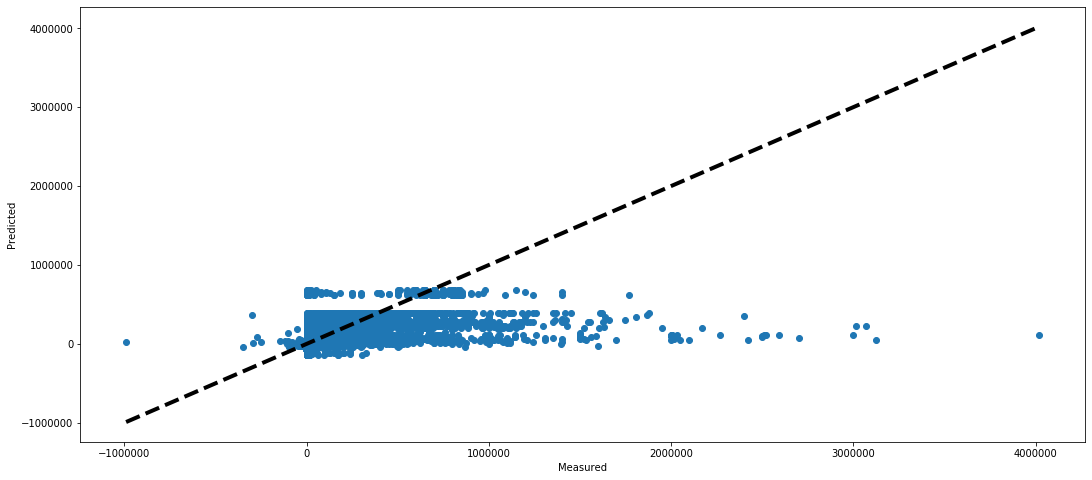

In [131]:

predGBR_TF = pd.DataFrame(data=predictionGBR_TF.flatten())

fig, ax = plt.subplots()
ax.scatter(timeFeatures_test_Y, predGBR_TF)
ax.plot([timeFeatures_test_Y.min(), timeFeatures_test_Y.max()], [timeFeatures_test_Y.min(), timeFeatures_test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

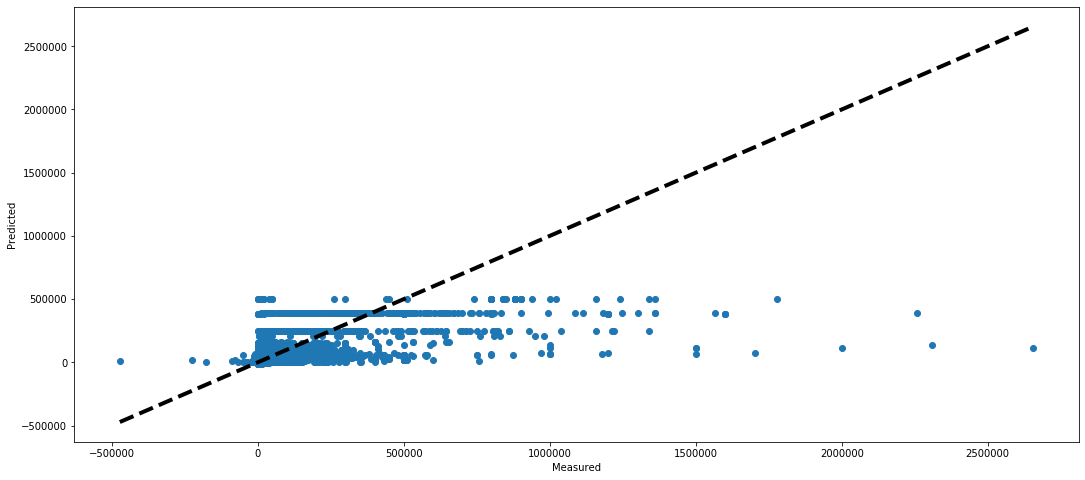

In [132]:

predGBR_TI = pd.DataFrame(data=predictionGBR_TI.flatten())

fig, ax = plt.subplots()
ax.scatter(timeIndex_test_Y, predGBR_TI)
ax.plot([timeIndex_test_Y.min(), timeIndex_test_Y.max()], [timeIndex_test_Y.min(), timeIndex_test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Since the timeIndex version performed better, let's use that data setup going forward.

I hypothesize that it might be better to predict by product and ignore many of the datasets which are simply impossible to predict (i.e. a single spike or similar). One way to bin these quantitatively is to train a model for each product, then select the best performing ones. However, this is highly inefficient and time consuming. Therefore, we can proxy this by hypothesizing that we will be able to best predict order_demand for products which have a low standard-deviation to mean ratio, also known as the coefficient of variation. In the real world, we'd want to ignore products that have below a certain amount of orders shipped (if they shipped on under 100 days for example, ignore that product). For now, due to the 10-hour rule, we will simply inspect a couple to generate models on.

In [133]:
means = original.groupby(['Product_Code'])['Order_Demand'].mean().reset_index()
stdevs = original.groupby(['Product_Code'])['Order_Demand'].std().reset_index()

ratio = pd.DataFrame(columns=['Product_Code', 'ratio'])
ratio['Product_Code'] = stdevs['Product_Code']
ratio['ratio'] = stdevs['Order_Demand'] / means['Order_Demand']

#sort by ratio
ratio.sort_values(['ratio'], inplace=True)

ratio.head(50)


,Product_Code,ratio
1687,1698,0.000000
1037,1048,0.096328
1306,1317,0.124935
1568,1579,0.134697
2029,2042,0.174331
2031,2044,0.176170
66,67,0.177924
2034,2047,0.193542
1351,1362,0.214270
2035,2048,0.230050


Now that we have the products with the lowest coefficient of variation, let's choose one to plot. We want to find a one that ships orders on quite a few dates, which we will do by inspection here. Product 1513 meets the criteria. Of course, for production we'd want to do a much more rigorous analysis, but this is simply a proof of concept.

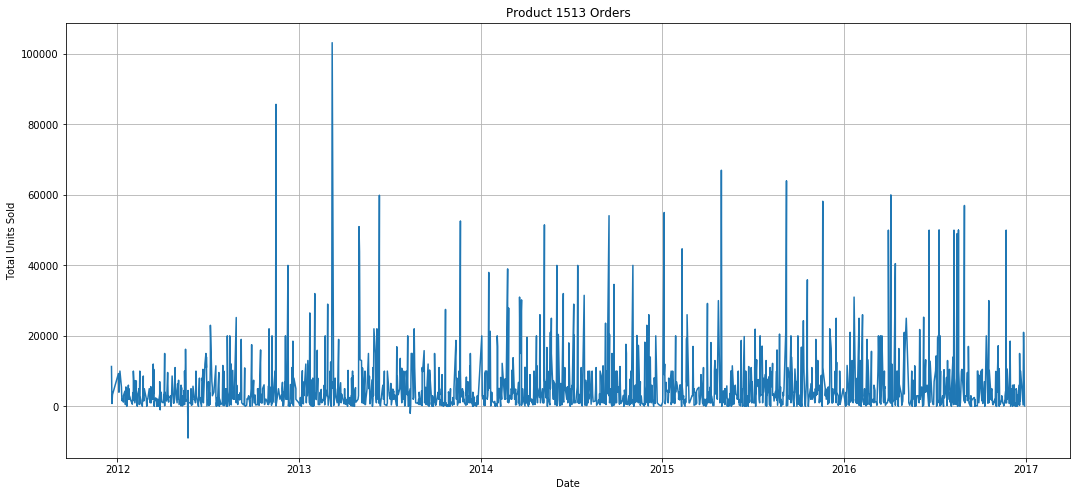

In [148]:
byProd = timeIndex.groupby(['Date', 'Product_Code', 'Warehouse'])['Order_Demand'].sum().reset_index()
byProd = byProd.set_index('Date')

is1513 = byProd['Product_Code'] == 1513
prod = byProd[is1513]
prodX = prod.index
prodY = prod['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(prodX, prodY)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Product 1513 Orders')
ax.grid()
plt.show()

Observe that outliers are not too common, specifically those about 60,000 units sold.

In [152]:
#use date for index
prod.head()
#prod = prod.set_index('Date')

prod_Train = prod[:'2015-12-31']
prod_Test = prod['2016-01-01':]

In [155]:
#don't worry about Product Category because all products with the same code are in the same category (this is obvious)
#split training data into X and Y
prod_train_Y = prod_Train['Order_Demand']
prod_train_X = prod_Train[['Warehouse', 'Product_Code']]
#split testing data into X and Y
prod_test_Y = prod_Test['Order_Demand']
prod_test_X = prod_Test[[ 'Warehouse', 'Product_Code']]